In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from sklearn.model_selection import GroupShuffleSplit 
import matplotlib.pyplot as plt
import nltk
from torch import optim
from nltk.corpus import stopwords
from models import utils, MLP
import json


In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

pretrained_embeddings, fasttext_vocab = utils.get_fasttext()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yarakhater/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Age Bias

## Data Preparation

In [47]:
annotation_split = True

In [48]:
#load dataset
train_df = pd.read_csv('./data/train_older_adult_annotations.csv',delimiter=',', encoding='latin-1')
test_df = pd.read_csv('./data/test_annotations.csv', delimiter=',')
df = pd.concat([test_df, train_df])

age_anxiety_df = pd.read_csv('./data/age_anxiety_full_responses.csv', delimiter=',')
age_experience_df = pd.read_csv('./data/age_experience_responses.csv', delimiter=',')
demographics_df = pd.read_csv('./data/demographics_responses.csv', delimiter=',')
anxiety_score_df = pd.read_csv('./data/respondent_anxiety_table.csv', delimiter=',')

df1 = pd.merge(demographics_df, anxiety_score_df, on='respondent_id')
merged_df = pd.merge(df, df1, on='respondent_id')

sentiment_labels = ['Very negative','Somewhat negative','Neutral','Somewhat positive','Very positive']
annotator_ids = merged_df['respondent_id'].unique().tolist()

id2label = {index: row for (index, row) in enumerate(sentiment_labels)} 
label2id = {row: index for (index, row) in enumerate(sentiment_labels)}

id2annotator = {index: row for (index, row) in enumerate(annotator_ids)}
annotator2id = {row: index for (index, row) in enumerate(annotator_ids)}
merged_df["annotation"] = merged_df["annotation"].map(label2id)
merged_df["respondent_id"] = merged_df["respondent_id"].map(annotator2id)
merged_df = utils.clean_text(merged_df, 'unit_text', stop_words)

/Users/yarakhater/Desktop/STAGE-POL/annotator_disagreement/models/utils.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace('[\W_]', ' ')
/Users/yarakhater/Desktop/STAGE-POL/annotator_disagreement/models/utils.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace('\d+', '')


In [49]:
merged_df['text_ids'] = merged_df['unit_text'].apply(lambda x: x.split())
merged_df['text_ids'] = merged_df['text_ids'].apply(fasttext_vocab)

In [50]:
if(annotation_split):
    splitter = GroupShuffleSplit(test_size=0.3, n_splits=2, random_state = 0)
    split = splitter.split(merged_df, groups=merged_df['unit_id'])
    train_inds, test_inds = next(split)
    train_df = merged_df.iloc[train_inds]
    test_df = merged_df.iloc[test_inds]
    train_df = train_df.sample(frac=1)
    test_df = test_df.sample(frac=1)
else: #annotator split
    #split into train and test with 70% of annotators in train and 30% in test
    train_annotators, test_annotators = train_test_split(merged_df["respondent_id"].unique(), train_size=0.7, random_state=0)
    print(len(train_annotators), len(test_annotators))
    train_df = merged_df[merged_df['respondent_id'].isin(train_annotators)]
    test_df = merged_df[merged_df['respondent_id'].isin(test_annotators)]

## train + test

In [51]:
classifier1 = MLP.train(pretrained_embeddings, train_df['text_ids'], train_df['respondent_id'], train_df['annotation'], len(train_df["annotation"].unique()), mode="text")

tensor(-0.0015, grad_fn=<MeanBackward0>) tensor(0.9975, grad_fn=<VarBackward0>)
Epoch [1/20], Loss: 1.3726
Epoch [2/20], Loss: 1.3666
Epoch [3/20], Loss: 1.3754
Epoch [4/20], Loss: 1.3832
Epoch [5/20], Loss: 1.3862
Epoch [6/20], Loss: 1.3894
Epoch [7/20], Loss: 1.3899
Epoch [8/20], Loss: 1.3938
Epoch [9/20], Loss: 1.3953
Epoch [10/20], Loss: 1.3944
Epoch [11/20], Loss: 1.3943
Epoch [12/20], Loss: 1.3934
Epoch [13/20], Loss: 1.3907
Epoch [14/20], Loss: 1.3842
Epoch [15/20], Loss: 1.3801
Epoch [16/20], Loss: 1.3749
Epoch [17/20], Loss: 1.3697
Epoch [18/20], Loss: 1.3676
Epoch [19/20], Loss: 1.3687
Epoch [20/20], Loss: 1.3640


In [52]:
predicted = MLP.test(test_df['text_ids'], test_df['respondent_id'], test_df['annotation'], classifier1, mode="text")

Accuracy of the model on the test set: 41.20707596253902 %


In [20]:
classifier_2 = MLP.train(pretrained_embeddings, train_df['text_ids'], train_df['respondent_id'], train_df['annotation'], len(train_df["annotation"].unique()), mode="text_annotators")

tensor(-0.0047, grad_fn=<MeanBackward0>) tensor(0.9955, grad_fn=<VarBackward0>)
Epoch [1/20], Loss: 1.3556
Epoch [2/20], Loss: 1.3415
Epoch [3/20], Loss: 1.3411
Epoch [4/20], Loss: 1.3437
Epoch [5/20], Loss: 1.3460
Epoch [6/20], Loss: 1.3472
Epoch [7/20], Loss: 1.3525
Epoch [8/20], Loss: 1.3320
Epoch [9/20], Loss: 1.3272
Epoch [10/20], Loss: 1.3207
Epoch [11/20], Loss: 1.3180
Epoch [12/20], Loss: 1.3065
Epoch [13/20], Loss: 1.3089
Epoch [14/20], Loss: 1.2996
Epoch [15/20], Loss: 1.3022
Epoch [16/20], Loss: 1.3036
Epoch [17/20], Loss: 1.2948
Epoch [18/20], Loss: 1.2835
Epoch [19/20], Loss: 1.2744
Epoch [20/20], Loss: 1.2719


In [21]:
predicted = MLP.test(test_df['text_ids'], test_df['respondent_id'], test_df['annotation'], classifier_2, mode="text_annotators")

Accuracy of the model on the test set: 48.88000438140095 %


In [22]:
classifier_3 = MLP.train(pretrained_embeddings, train_df['text_ids'], train_df['respondent_id'], train_df['annotation'], len(train_df["annotation"].unique()), mode="text_groups", nb_groups = 5)

tensor(0.0050, grad_fn=<MeanBackward0>) tensor(0.9945, grad_fn=<VarBackward0>)
Epoch [1/20], Loss: 1.2325
Epoch [2/20], Loss: 1.2218
Epoch [3/20], Loss: 1.2038
Epoch [4/20], Loss: 1.1833
Epoch [5/20], Loss: 1.1687
Epoch [6/20], Loss: 1.1644
Epoch [7/20], Loss: 1.1625
Epoch [8/20], Loss: 1.1604
Epoch [9/20], Loss: 1.1556
Epoch [10/20], Loss: 1.1522
Epoch [11/20], Loss: 1.1519
Epoch [12/20], Loss: 1.1564
Epoch [13/20], Loss: 1.1562
Epoch [14/20], Loss: 1.1528
Epoch [15/20], Loss: 1.1500
Epoch [16/20], Loss: 1.1495
Epoch [17/20], Loss: 1.1434
Epoch [18/20], Loss: 1.1404
Epoch [19/20], Loss: 1.1401
Epoch [20/20], Loss: 1.1366


In [23]:
predicted = MLP.test(test_df['text_ids'], test_df['respondent_id'], test_df['annotation'], classifier_3, mode="text_groups")

Accuracy of the model on the test set: 46.289501067966484 %


# GAB HATE

## Data preperation

In [32]:
demographics_df = pd.read_csv('./data/ghc/AnnotatorIAT_and_Attitudes.csv',delimiter=',', encoding='latin-1')
# train_df = pd.read_csv("data/ghc/ghc_train.tsv", delimiter='\t')
# test_df = pd.read_csv("data/ghc/ghc_test.tsv", delimiter='\t')
annotations_df = pd.read_csv("data/ghc/GabHateCorpus_annotations.tsv", delimiter='\t')
annotations_df = annotations_df[['Annotator', 'Text', 'Hate',"ID"]]

merged_df = utils.clean_text(annotations_df, 'Text', stop_words)
merged_df['text_ids'] = merged_df['Text'].apply(lambda x: x.split())
merged_df['text_ids'] = merged_df['text_ids'].apply(fasttext_vocab)

splitter = GroupShuffleSplit(test_size=0.3, n_splits=2, random_state = 0)
split = splitter.split(annotations_df, groups=annotations_df['ID'])
train_inds, test_inds = next(split)
train_df = annotations_df.iloc[train_inds]
test_df = annotations_df.iloc[test_inds]
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

/Users/yarakhater/Desktop/STAGE-POL/annotator_disagreement/models/utils.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace('[\W_]', ' ')
/Users/yarakhater/Desktop/STAGE-POL/annotator_disagreement/models/utils.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace('\d+', '')


## train + test

In [39]:
classifier_1 = MLP.train(pretrained_embeddings, train_df['text_ids'], train_df['Annotator'],train_df['Hate'], len(train_df["Hate"].unique()), mode="text")

tensor(-0.0465, grad_fn=<MeanBackward0>) tensor(0.9536, grad_fn=<VarBackward0>)
Epoch [1/20], Loss: 0.3386
Epoch [2/20], Loss: 0.3442
Epoch [3/20], Loss: 0.3484
Epoch [4/20], Loss: 0.3515
Epoch [5/20], Loss: 0.3523
Epoch [6/20], Loss: 0.3523
Epoch [7/20], Loss: 0.3515
Epoch [8/20], Loss: 0.3505
Epoch [9/20], Loss: 0.3483
Epoch [10/20], Loss: 0.3465
Epoch [11/20], Loss: 0.3447
Epoch [12/20], Loss: 0.3438
Epoch [13/20], Loss: 0.3410
Epoch [14/20], Loss: 0.3396
Epoch [15/20], Loss: 0.3382
Epoch [16/20], Loss: 0.3369
Epoch [17/20], Loss: 0.3351
Epoch [18/20], Loss: 0.3316
Epoch [19/20], Loss: 0.3306
Epoch [20/20], Loss: 0.3289


In [40]:
predicted = MLP.test(test_df['text_ids'], test_df['Annotator'], test_df['Hate'], classifier_1, mode="text")

Accuracy of the model on the test set: 86.79093005380477 %


In [41]:
classifier_2 = MLP.train(pretrained_embeddings, train_df['text_ids'], train_df['Annotator'],train_df['Hate'], len(train_df["Hate"].unique()), mode="text_annotators")

tensor(-0.0098, grad_fn=<MeanBackward0>) tensor(1.0000, grad_fn=<VarBackward0>)
Epoch [1/20], Loss: 0.2561
Epoch [2/20], Loss: 0.2558
Epoch [3/20], Loss: 0.2547
Epoch [4/20], Loss: 0.2526
Epoch [5/20], Loss: 0.2592
Epoch [6/20], Loss: 0.2610
Epoch [7/20], Loss: 0.2645
Epoch [8/20], Loss: 0.2684
Epoch [9/20], Loss: 0.2709
Epoch [10/20], Loss: 0.2745
Epoch [11/20], Loss: 0.2716
Epoch [12/20], Loss: 0.2719
Epoch [13/20], Loss: 0.2723
Epoch [14/20], Loss: 0.2729
Epoch [15/20], Loss: 0.2745
Epoch [16/20], Loss: 0.2750
Epoch [17/20], Loss: 0.2727
Epoch [18/20], Loss: 0.2721
Epoch [19/20], Loss: 0.2713
Epoch [20/20], Loss: 0.2722


In [42]:
predicted = MLP.test(test_df['text_ids'], test_df['Annotator'], test_df['Hate'], classifier_2, mode="text_annotators")

Accuracy of the model on the test set: 87.72482705611068 %


In [43]:
classifier_3 = MLP.train(pretrained_embeddings, train_df['text_ids'], train_df['Annotator'],train_df['Hate'], len(train_df["Hate"].unique()), mode="text_groups", nb_groups = 5)

tensor(0.0132, grad_fn=<MeanBackward0>) tensor(0.9628, grad_fn=<VarBackward0>)
Epoch [1/20], Loss: 0.2494
Epoch [2/20], Loss: 0.2494
Epoch [3/20], Loss: 0.2494
Epoch [4/20], Loss: 0.2509
Epoch [5/20], Loss: 0.2511
Epoch [6/20], Loss: 0.2498
Epoch [7/20], Loss: 0.2494
Epoch [8/20], Loss: 0.2488
Epoch [9/20], Loss: 0.2494
Epoch [10/20], Loss: 0.2501
Epoch [11/20], Loss: 0.2494
Epoch [12/20], Loss: 0.2495
Epoch [13/20], Loss: 0.2485
Epoch [14/20], Loss: 0.2478
Epoch [15/20], Loss: 0.2471
Epoch [16/20], Loss: 0.2464
Epoch [17/20], Loss: 0.2457
Epoch [18/20], Loss: 0.2440
Epoch [19/20], Loss: 0.2417
Epoch [20/20], Loss: 0.2406


In [44]:
predicted = MLP.test(test_df['text_ids'], test_df['Annotator'], test_df['Hate'], classifier_3, mode="text_groups")

Accuracy of the model on the test set: 86.72559569561875 %


# Toxicity Ratings

## Data preperation

In [26]:
annotations_df = pd.read_csv("data/Toxicity_content/toxic_content_annotation", delimiter=',')
text_df = pd.read_csv("data/Toxicity_content/toxic_content_sentences", delimiter=',')
annotators_df = pd.read_csv("data/Toxicity_content/toxic_content_workers", delimiter=',')

text_df = utils.clean_text(text_df, 'comment', stop_words)

text_df['text_ids'] = text_df['comment'].apply(lambda x: x.split())
text_df['text_ids'] = text_df['text_ids'].apply(fasttext_vocab)

annotations_df["text_ids"] = annotations_df["sentence_id"].map(text_df.set_index("sentence_id")["text_ids"])
annotations_df["gender"] = annotations_df["worker_id"].map(annotators_df.set_index("worker_id")["gender"])


annotator_ids = annotators_df['worker_id'].unique().tolist()
id2annotator = {index: row for (index, row) in enumerate(annotator_ids)}
annotator2id = {row: index for (index, row) in enumerate(annotator_ids)}
annotations_df["worker_id"] = annotations_df["worker_id"].map(annotator2id)
annotators_df["worker_id"] = annotators_df["worker_id"].map(annotator2id)

splitter = GroupShuffleSplit(test_size=0.3, n_splits=2, random_state = 1)
split = splitter.split(annotations_df, groups=annotations_df['sentence_id'])
train_inds, test_inds = next(split)
train_df = annotations_df.iloc[train_inds]
test_df = annotations_df.iloc[test_inds]
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

/Users/yarakhater/Desktop/annotator_disagreement/models/utils.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace('[\W_]', ' ')
/Users/yarakhater/Desktop/annotator_disagreement/models/utils.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace('\d+', '')


In [114]:
#show how many unique labels each sentence has
x = annotations_df.groupby('sentence_id').agg({'toxic_score': lambda x: list(x)})
x['toxic_score'].apply(lambda x: len(set(x))).value_counts()/len(x)


1    0.469103
2    0.394415
3    0.123282
4    0.012904
5    0.000297
Name: toxic_score, dtype: float64

<Axes: xlabel='Toxicity Score'>

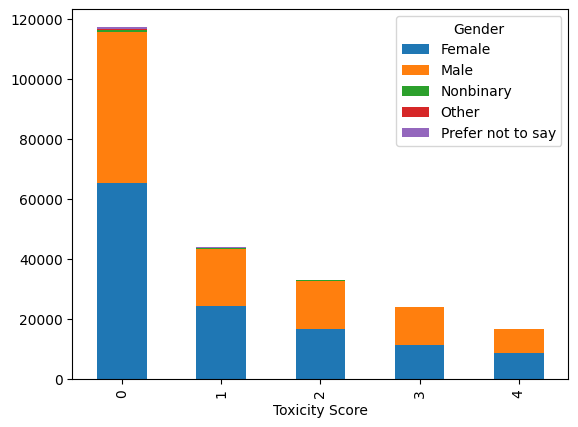

In [30]:
data = pd.DataFrame({'Toxicity Score': annotations_df['toxic_score'], 'Gender': annotations_df['gender']})
grouped_data = data.groupby(['Toxicity Score', 'Gender']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Toxicity Score', columns='Gender', values='Count')
pivot_table.plot(kind='bar', stacked=True)


## train + test

In [54]:
classifier_1 = MLP.train(pretrained_embeddings, train_df['text_ids'], train_df['worker_id'], train_df['toxic_score'], len(train_df["toxic_score"].unique()), mode="text")

tensor(0.0002, grad_fn=<MeanBackward0>) tensor(1.0008, grad_fn=<VarBackward0>)
Epoch [1/20], Loss: 1.3204
Epoch [2/20], Loss: 1.3210
Epoch [3/20], Loss: 1.3192
Epoch [4/20], Loss: 1.3142
Epoch [5/20], Loss: 1.3087
Epoch [6/20], Loss: 1.3051
Epoch [7/20], Loss: 1.3014
Epoch [8/20], Loss: 1.2993
Epoch [9/20], Loss: 1.2967
Epoch [10/20], Loss: 1.2952
Epoch [11/20], Loss: 1.2945
Epoch [12/20], Loss: 1.2923
Epoch [13/20], Loss: 1.2884
Epoch [14/20], Loss: 1.2882
Epoch [15/20], Loss: 1.2853
Epoch [16/20], Loss: 1.2846
Epoch [17/20], Loss: 1.2823
Epoch [18/20], Loss: 1.2816
Epoch [19/20], Loss: 1.2798
Epoch [20/20], Loss: 1.2797


In [56]:
predicted = MLP.test(test_df['text_ids'], test_df['worker_id'], test_df['toxic_score'], classifier_1, mode="text")

Accuracy of the model on the test set: 50.221939496748654 %


In [57]:
classifier_2 = MLP.train(pretrained_embeddings, train_df['text_ids'], train_df['worker_id'], train_df['toxic_score'], len(train_df["toxic_score"].unique()), mode="text_annotators")

tensor(-1.9485e-05, grad_fn=<MeanBackward0>) tensor(1.0016, grad_fn=<VarBackward0>)
Epoch [1/20], Loss: 1.1792
Epoch [2/20], Loss: 1.1004
Epoch [3/20], Loss: 1.0954
Epoch [4/20], Loss: 1.0756
Epoch [5/20], Loss: 1.0536
Epoch [6/20], Loss: 1.0278
Epoch [7/20], Loss: 0.9926
Epoch [8/20], Loss: 0.9761
Epoch [9/20], Loss: 0.9617
Epoch [10/20], Loss: 0.9552
Epoch [11/20], Loss: 0.9399
Epoch [12/20], Loss: 0.9162
Epoch [13/20], Loss: 0.8946
Epoch [14/20], Loss: 0.8656
Epoch [15/20], Loss: 0.8720
Epoch [16/20], Loss: 0.8654
Epoch [17/20], Loss: 0.8738
Epoch [18/20], Loss: 0.8584
Epoch [19/20], Loss: 0.8430
Epoch [20/20], Loss: 0.8084


In [59]:
predicted = MLP.test(test_df['text_ids'], test_df['worker_id'], test_df['toxic_score'], classifier_2, mode="text_annotators")

Accuracy of the model on the test set: 47.414475544246535 %


In [90]:
classifier_3 = MLP.train(pretrained_embeddings, train_df['text_ids'], train_df['worker_id'], train_df['toxic_score'], len(train_df["toxic_score"].unique()), mode="text_groups", nb_groups = 5)

tensor(0.0001, grad_fn=<MeanBackward0>) tensor(0.9984, grad_fn=<VarBackward0>)
Epoch [1/20], Loss: 0.6160
Epoch [2/20], Loss: 0.5778
Epoch [3/20], Loss: 0.5433
Epoch [4/20], Loss: 0.5277
Epoch [5/20], Loss: 0.5220
Epoch [6/20], Loss: 0.5205
Epoch [7/20], Loss: 0.5190
Epoch [8/20], Loss: 0.5166
Epoch [9/20], Loss: 0.5148
Epoch [10/20], Loss: 0.5130
Epoch [11/20], Loss: 0.5128
Epoch [12/20], Loss: 0.5081
Epoch [13/20], Loss: 0.4990
Epoch [14/20], Loss: 0.4987
Epoch [15/20], Loss: 0.4910
Epoch [16/20], Loss: 0.4869
Epoch [17/20], Loss: 0.4825
Epoch [18/20], Loss: 0.4789
Epoch [19/20], Loss: 0.4757
Epoch [20/20], Loss: 0.4723


In [91]:
predicted = MLP.test(test_df['text_ids'], test_df['worker_id'], test_df['toxic_score'], classifier_3, mode="text_groups")

Accuracy of the model on the test set: 51.75996607294317 %


In [92]:
classifier_3.load_state_dict(classifier_3.state_dict())
classifier_3.eval()
group_assignment_trained = classifier_3.group_assignment

In [93]:
clusters = group_assignment_trained.max(dim=1).indices
clusters

tensor([0, 0, 0,  ..., 4, 3, 1])

<Axes: xlabel='Clusters'>

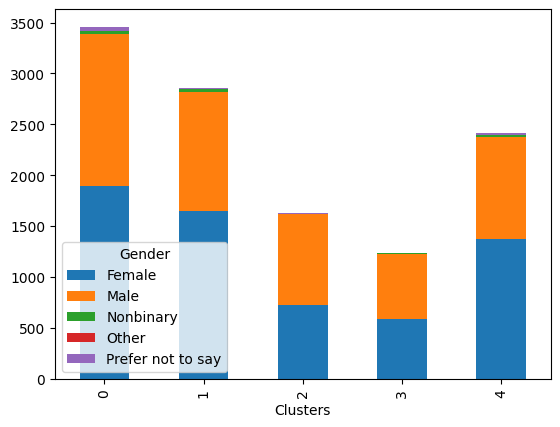

In [94]:
data = pd.DataFrame({'Clusters': clusters, 'Gender': annotators_df['gender']})
grouped_data = data.groupby(['Clusters', 'Gender']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Clusters', columns='Gender', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Clusters'>

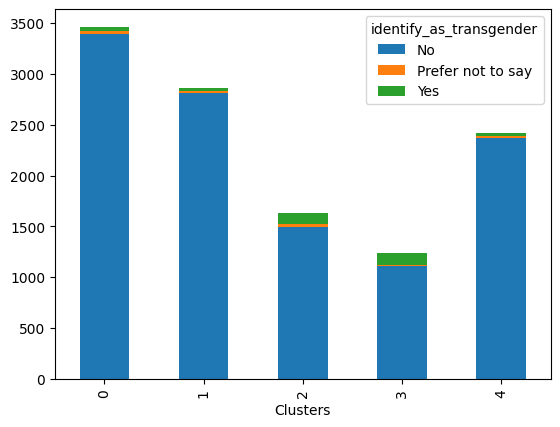

In [95]:
data = pd.DataFrame({'Clusters': clusters, 'identify_as_transgender': annotators_df['identify_as_transgender']})
grouped_data = data.groupby(['Clusters', 'identify_as_transgender']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Clusters', columns='identify_as_transgender', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Clusters'>

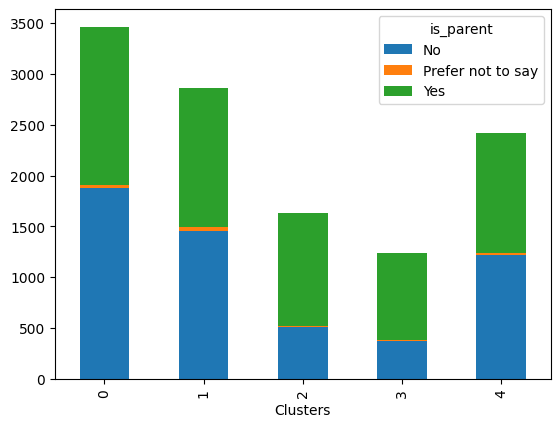

In [96]:
data = pd.DataFrame({'Clusters': clusters, 'is_parent': annotators_df['is_parent']})
grouped_data = data.groupby(['Clusters', 'is_parent']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Clusters', columns='is_parent', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Clusters'>

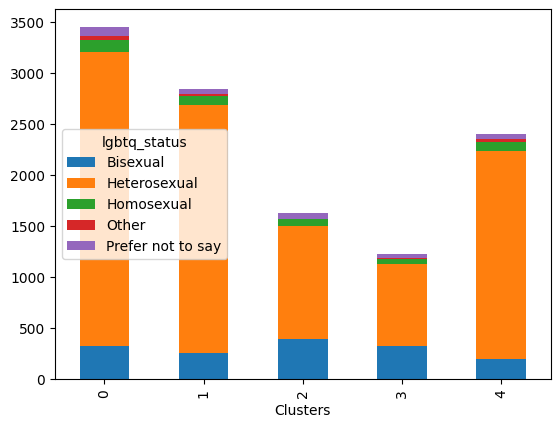

In [97]:
data = pd.DataFrame({'Clusters': clusters, 'lgbtq_status': annotators_df['lgbtq_status']})
grouped_data = data.groupby(['Clusters', 'lgbtq_status']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Clusters', columns='lgbtq_status', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Clusters'>

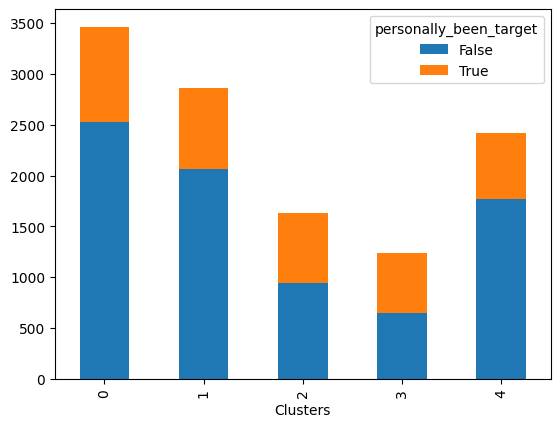

In [98]:
data = pd.DataFrame({'Clusters': clusters, 'personally_been_target': annotators_df['personally_been_target']})
grouped_data = data.groupby(['Clusters', 'personally_been_target']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Clusters', columns='personally_been_target', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Clusters'>

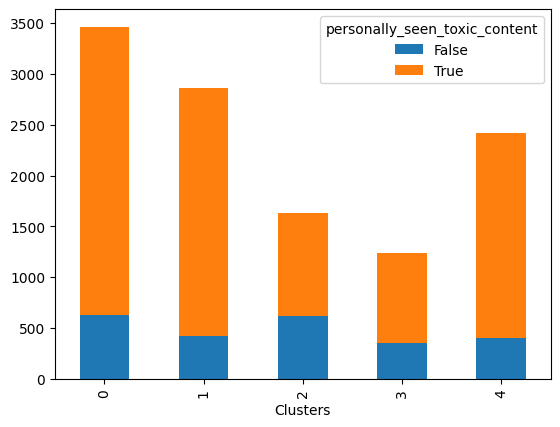

In [99]:
data = pd.DataFrame({'Clusters': clusters, 'personally_seen_toxic_content': annotators_df['personally_seen_toxic_content']})
grouped_data = data.groupby(['Clusters', 'personally_seen_toxic_content']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Clusters', columns='personally_seen_toxic_content', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Clusters'>

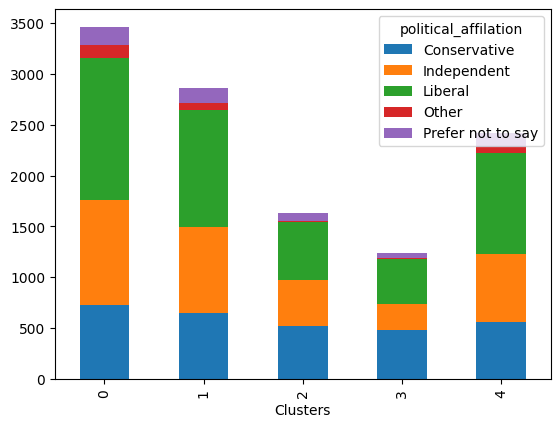

In [100]:
data = pd.DataFrame({'Clusters': clusters, 'political_affilation': annotators_df['political_affilation']})
grouped_data = data.groupby(['Clusters', 'political_affilation']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Clusters', columns='political_affilation', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Clusters'>

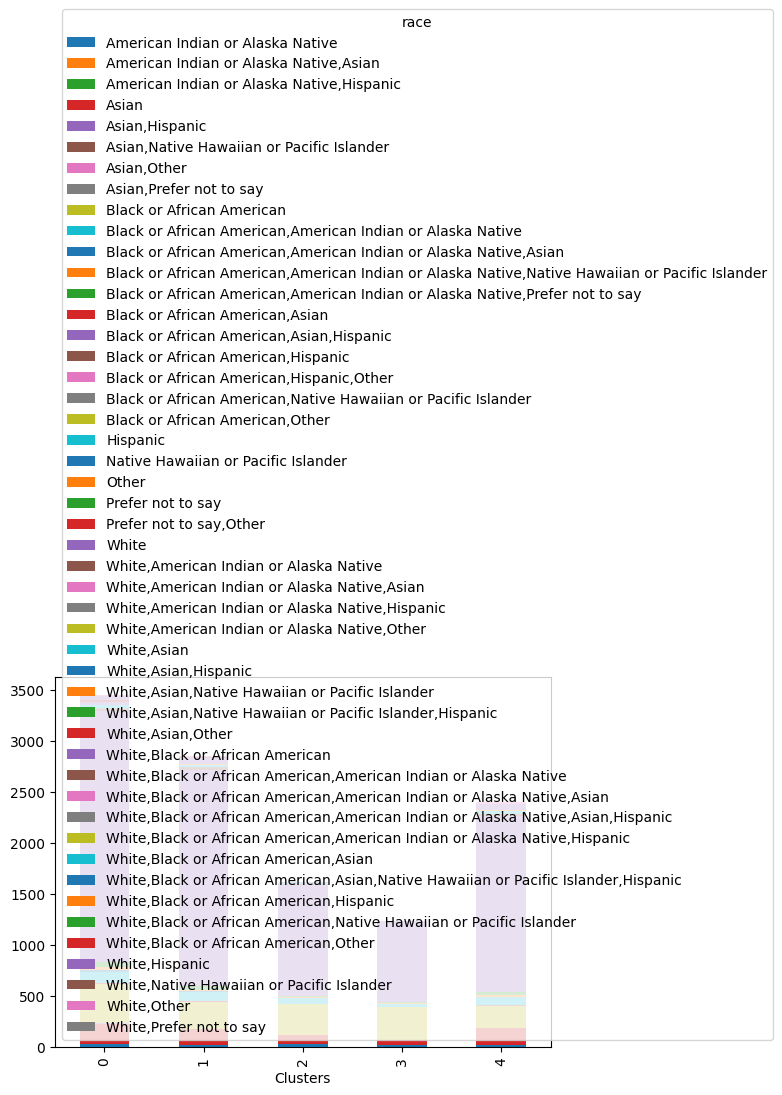

In [101]:
data = pd.DataFrame({'Clusters': clusters, 'race': annotators_df['race']})
grouped_data = data.groupby(['Clusters', 'race']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Clusters', columns='race', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Clusters'>

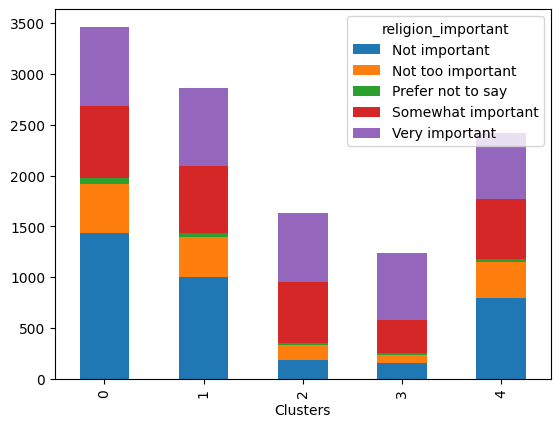

In [102]:
data = pd.DataFrame({'Clusters': clusters, 'religion_important': annotators_df['religion_important']})
grouped_data = data.groupby(['Clusters', 'religion_important']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Clusters', columns='religion_important', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Clusters'>

/Users/yarakhater/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 128 (\x80) missing from current font.
  func(*args, **kwargs)
/Users/yarakhater/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 147 (\x93) missing from current font.
  func(*args, **kwargs)
/Users/yarakhater/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yarakhater/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


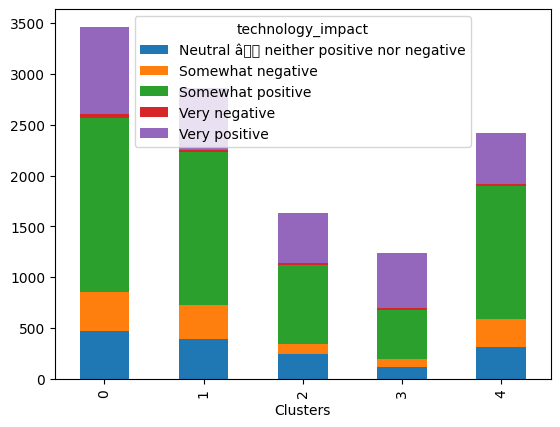

In [103]:
data = pd.DataFrame({'Clusters': clusters, 'technology_impact': annotators_df['technology_impact']})
grouped_data = data.groupby(['Clusters', 'technology_impact']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Clusters', columns='technology_impact', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Clusters'>

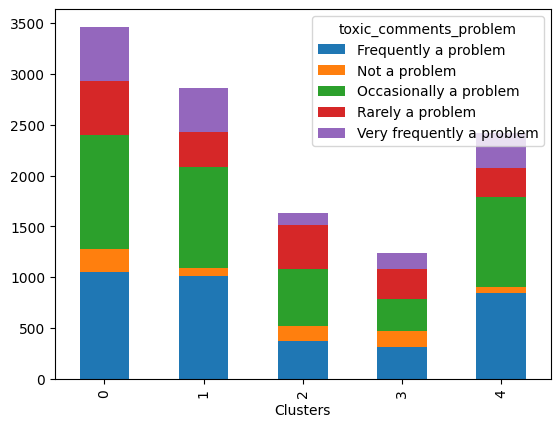

In [104]:
data = pd.DataFrame({'Clusters': clusters, 'toxic_comments_problem': annotators_df['toxic_comments_problem']})
grouped_data = data.groupby(['Clusters', 'toxic_comments_problem']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Clusters', columns='toxic_comments_problem', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Clusters'>

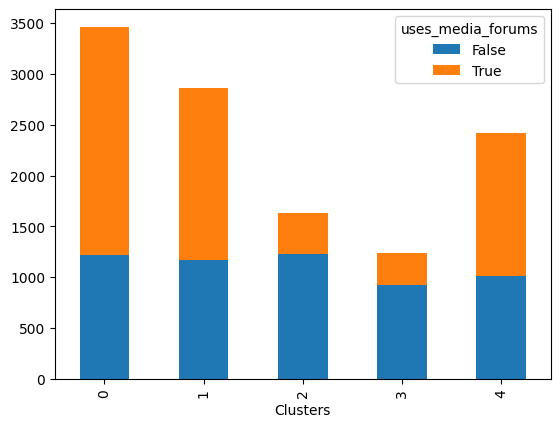

In [105]:
data = pd.DataFrame({'Clusters': clusters, 'uses_media_forums': annotators_df['uses_media_forums']})
grouped_data = data.groupby(['Clusters', 'uses_media_forums']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Clusters', columns='uses_media_forums', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Clusters'>

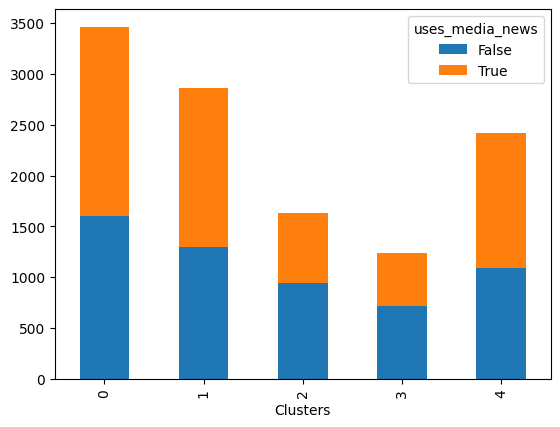

In [106]:
data = pd.DataFrame({'Clusters': clusters, 'uses_media_news': annotators_df['uses_media_news']})
grouped_data = data.groupby(['Clusters', 'uses_media_news']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Clusters', columns='uses_media_news', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Clusters'>

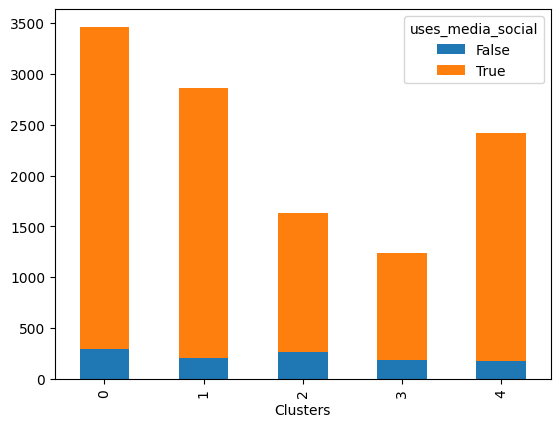

In [107]:
data = pd.DataFrame({'Clusters': clusters, 'uses_media_social': annotators_df['uses_media_social']})
grouped_data = data.groupby(['Clusters', 'uses_media_social']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Clusters', columns='uses_media_social', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Clusters'>

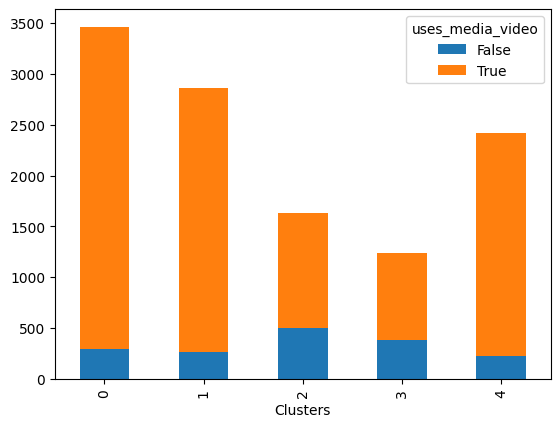

In [108]:
data = pd.DataFrame({'Clusters': clusters, 'uses_media_video': annotators_df['uses_media_video']})
grouped_data = data.groupby(['Clusters', 'uses_media_video']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Clusters', columns='uses_media_video', values='Count')
pivot_table.plot(kind='bar', stacked=True)

# Go Emotions

## Data preperation

In [7]:
df = pd.read_csv('./data/goemotions/full_dataset/goemotions-full.csv', header=0, delimiter=';')
df = df.drop(columns=['subreddit', 'link_id', 'parent_id', "created_utc"])


with open('./data/goemotions/full_dataset/ekman_mapping.json', 'r') as f:
    data = f.read()

dictionary = json.loads(data)

ekman_labels = list(dictionary.keys())\

#modify dataset to only contain ekman labels
for key, value in dictionary.items():
    dfs = []
    for v in value:
        dfs.append(df[v])
        df = df.drop(columns=[v])
    df_combined = pd.concat(dfs, axis=1)
    df[key] = df_combined.iloc[:, 0:len(value)].apply(lambda x: int(x.any()), axis=1)

row_sum = df[ekman_labels].sum(axis=1)
has_multiple_classes = (row_sum > 1)

# remove rows that have more than one class and those who are not annotated 
df = df[~has_multiple_classes & df["example_very_unclear"] ==False]

#add a "label" column that contains the index of the ekman label and not the name   
df['label'] = df[ekman_labels].idxmax(axis=1)

df = df[["id","text", "label", "rater_id"]]

id2label = {index: row for (index, row) in enumerate(ekman_labels)} 
label2id = {row: index for (index, row) in enumerate(ekman_labels)}

df["label"] = df["label"].map(label2id)
# df["rater_id"] = df["rater_id"].astype(str)

df = utils.clean_text(df, 'text', stop_words)

df['text_ids'] = df['text'].apply(lambda x: x.split())
df['text_ids'] = df['text_ids'].apply(fasttext_vocab)

splitter = GroupShuffleSplit(test_size=0.3, n_splits=2, random_state = 7)
split = splitter.split(df, groups=df['id'])
train_inds, test_inds = next(split)

train_df = df.iloc[train_inds]
test_df = df.iloc[test_inds]



/Users/yarakhater/Desktop/annotator_disagreement/models/utils.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace('[\W_]', ' ')
/Users/yarakhater/Desktop/annotator_disagreement/models/utils.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace('\d+', '')


## train + test

In [83]:
classifier_1 = MLP.train(pretrained_embeddings, train_df['text_ids'], train_df['rater_id'], train_df['label'], len(train_df["label"].unique()), mode="text")

tensor(0.0213, grad_fn=<MeanBackward0>) tensor(1.0161, grad_fn=<VarBackward0>)
Epoch [1/20], Loss: 0.9764
Epoch [2/20], Loss: 0.9305
Epoch [3/20], Loss: 0.9039
Epoch [4/20], Loss: 0.8889
Epoch [5/20], Loss: 0.8839
Epoch [6/20], Loss: 0.8926
Epoch [7/20], Loss: 0.9049
Epoch [8/20], Loss: 0.8957
Epoch [9/20], Loss: 0.8863
Epoch [10/20], Loss: 0.8857
Epoch [11/20], Loss: 0.8899
Epoch [12/20], Loss: 0.8907
Epoch [13/20], Loss: 0.8864
Epoch [14/20], Loss: 0.8634
Epoch [15/20], Loss: 0.8402
Epoch [16/20], Loss: 0.8331
Epoch [17/20], Loss: 0.8351
Epoch [18/20], Loss: 0.8324
Epoch [19/20], Loss: 0.8183
Epoch [20/20], Loss: 0.8085


In [84]:
predicted = MLP.test(test_df['text_ids'], test_df['rater_id'], test_df['label'], classifier_1, mode="text")

Accuracy of the model on the test set: 54.294006349613575 %


In [85]:
classifier_2 = MLP.train(pretrained_embeddings, train_df['text_ids'], train_df['rater_id'], train_df['label'], len(train_df["label"].unique()), mode="text_annotators")

tensor(-0.0076, grad_fn=<MeanBackward0>) tensor(1.0044, grad_fn=<VarBackward0>)
Epoch [1/20], Loss: 0.9169
Epoch [2/20], Loss: 0.8841
Epoch [3/20], Loss: 0.8696
Epoch [4/20], Loss: 0.8510
Epoch [5/20], Loss: 0.8717
Epoch [6/20], Loss: 0.8472
Epoch [7/20], Loss: 0.8605
Epoch [8/20], Loss: 0.8674
Epoch [9/20], Loss: 0.8902
Epoch [10/20], Loss: 0.8813
Epoch [11/20], Loss: 0.8609
Epoch [12/20], Loss: 0.8377
Epoch [13/20], Loss: 0.8431
Epoch [14/20], Loss: 0.8300
Epoch [15/20], Loss: 0.8209
Epoch [16/20], Loss: 0.8128
Epoch [17/20], Loss: 0.8089
Epoch [18/20], Loss: 0.7775
Epoch [19/20], Loss: 0.7748
Epoch [20/20], Loss: 0.7742


In [86]:
predicted = MLP.test(test_df['text_ids'], test_df['rater_id'], test_df['label'], classifier_2, mode="text_annotators")

Accuracy of the model on the test set: 55.517429368566205 %


In [87]:
classifier_3 = MLP.train(pretrained_embeddings, train_df['text_ids'], train_df['rater_id'], train_df['label'], len(train_df["label"].unique()), mode="text_groups", nb_groups = 5)

tensor(-0.0149, grad_fn=<MeanBackward0>) tensor(1.0150, grad_fn=<VarBackward0>)
Epoch [1/20], Loss: 0.2471
Epoch [2/20], Loss: 0.2378
Epoch [3/20], Loss: 0.2425
Epoch [4/20], Loss: 0.2404
Epoch [5/20], Loss: 0.2435
Epoch [6/20], Loss: 0.2448
Epoch [7/20], Loss: 0.2440
Epoch [8/20], Loss: 0.2420
Epoch [9/20], Loss: 0.2385
Epoch [10/20], Loss: 0.2353
Epoch [11/20], Loss: 0.2340
Epoch [12/20], Loss: 0.2305
Epoch [13/20], Loss: 0.2263
Epoch [14/20], Loss: 0.2221
Epoch [15/20], Loss: 0.2167
Epoch [16/20], Loss: 0.2129
Epoch [17/20], Loss: 0.2079
Epoch [18/20], Loss: 0.2047
Epoch [19/20], Loss: 0.2018
Epoch [20/20], Loss: 0.1975


In [88]:
predicted = MLP.test(test_df['text_ids'], test_df['rater_id'], test_df['label'], classifier_3, mode="text_groups")


Accuracy of the model on the test set: 54.194593207837606 %
